In [1]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data

from utils.GNN_data import *
from utils.GNN_architecture import Transformer
from utils.train_model import train_model
from utils.evaluate_model import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./saved_model', help='saved GNN model directory')
args = parser.parse_args([])
'''
This use mean pooling and dropout rate 0.5
Learning rate = 0.1 and update
'''

'\nThis use mean pooling and dropout rate 0.5\nLearning rate = 0.1 and update\n'

In [3]:

def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, E=np.float64(label * 200.00))
    return data

# Data loading

In [4]:
import glob

# Read the Result.txt file and extract filenames and their labels
file_labels = {}
with open('Results.txt', 'r') as file:
    for line in file:
        # Skip empty lines or lines starting with a header
        if line.strip() == "" or "E/Es" in line:
            continue
        
        try:
            file, label = line.strip().split(', ')
            filename, filetype = file.strip().split('.')
            label = float(label)  # Convert the label to a float
            file_labels[filename] = label
        except ValueError:
            print(f"Skipping line due to invalid format: {line.strip()}")

# Load all data points using the filenames and labels from the file_labels dictionary
dataset = [load_inp_data(f"inp_files/{file}.inp", label) for file, label in file_labels.items()]

# Print out the loaded data
for file, label in file_labels.items():
    print(f"Filename: {file}, E/Es: {label}")

Filename: Kag10L_R00_n01, E/Es: 0.0166712805176
Filename: Kag10L_R01_n01, E/Es: 0.0165968310547
Filename: Kag10L_R01_n02, E/Es: 0.016587890625
Filename: Kag10L_R01_n03, E/Es: 0.0165587841797
Filename: Kag10L_R01_n04, E/Es: 0.0165454077148
Filename: Kag10L_R01_n05, E/Es: 0.0165114807129
Filename: Kag10L_R01_n06, E/Es: 0.0165991699219
Filename: Kag10L_R01_n07, E/Es: 0.0166008166504
Filename: Kag10L_R01_n08, E/Es: 0.0165159558105
Filename: Kag10L_R01_n09, E/Es: 0.0165478527832
Filename: Kag10L_R01_n10, E/Es: 0.0165925073242
Filename: Kag10L_R01_n11, E/Es: 0.0166401220703
Filename: Kag10L_R01_n12, E/Es: 0.0165739355469
Filename: Kag10L_R01_n13, E/Es: 0.0165640649414
Filename: Kag10L_R01_n14, E/Es: 0.016555604248
Filename: Kag10L_R01_n15, E/Es: 0.0165907177734
Filename: Kag10L_R01_n16, E/Es: 0.0164631066895
Filename: Kag10L_R01_n17, E/Es: 0.0164945996094
Filename: Kag10L_R01_n18, E/Es: 0.01650796875
Filename: Kag10L_R01_n19, E/Es: 0.016533104248
Filename: Kag10L_R01_n20, E/Es: 0.01658396484

In [5]:
dataset

[Data(x=[104, 2], edge_index=[2, 180], E=3.3342561035200005),
 Data(x=[104, 2], edge_index=[2, 180], E=3.31936621094),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3175781250000003),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3117568359400003),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3090815429599996),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3022961425800004),
 Data(x=[104, 2], edge_index=[2, 180], E=3.31983398438),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3201633300799998),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3031911621),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3095705566399998),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3185014648399997),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3280244140599997),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3147871093799997),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3128129882799997),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3111208496),
 Data(x=[104, 2], edge_index=[2, 180], E=3.31814355468),
 Data(x=[104, 2], edge_index=[2, 18

In [6]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.001
overlap=args.overlap

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
dataset = [make_undirected(data) for data in dataset]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

dataset = normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 800
Number of test graphs: 100
Number of vali graphs: 101


In [7]:
dataset[0]

Data(x=[104, 2], edge_index=[2, 360], E=3.3342561035200005)

# GNN architecture

In [8]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = Transformer(dim_h=64, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-5)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

Transformer(
  (conv1): TransformerConv(2, 64, heads=4)
  (conv2): TransformerConv(256, 64, heads=4)
  (conv3): TransformerConv(256, 64, heads=4)
  (lin1): Linear(in_features=768, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)
Number of parameters: 644481


## Training

In [9]:
train_losses, test_losses, R2_trainings, R2_tests, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], LR [0.001], Loss[Train: 1.563, Test: 0.779], R2[Train: -0.929, Test: -0.058]
Epoch [2], LR [0.001], Loss[Train: 0.850, Test: 0.738], R2[Train: -0.049, Test: -0.002]
Epoch [3], LR [0.001], Loss[Train: 0.828, Test: 0.762], R2[Train: -0.022, Test: -0.035]
Epoch [4], LR [0.001], Loss[Train: 0.853, Test: 0.809], R2[Train: -0.053, Test: -0.099]
Epoch [5], LR [0.001], Loss[Train: 0.880, Test: 0.728], R2[Train: -0.087, Test: 0.011]
Epoch [6], LR [0.001], Loss[Train: 0.853, Test: 0.873], R2[Train: -0.053, Test: -0.186]
Epoch [7], LR [0.001], Loss[Train: 0.812, Test: 0.772], R2[Train: -0.002, Test: -0.048]
Epoch [8], LR [0.001], Loss[Train: 0.807, Test: 0.799], R2[Train: 0.004, Test: -0.085]
Epoch [9], LR [0.001], Loss[Train: 0.813, Test: 0.734], R2[Train: -0.004, Test: 0.003]
Epoch [10], LR [0.001], Loss[Train: 0.802, Test: 0.769], R2[Train: 0.010, Test: -0.044]
Epoch [11], LR [0.001], Loss[Train: 0.822, Test: 0.829], R2[Train: -0.014, Test: -0.126]
Epoch [12], LR [0.001], Loss[Train

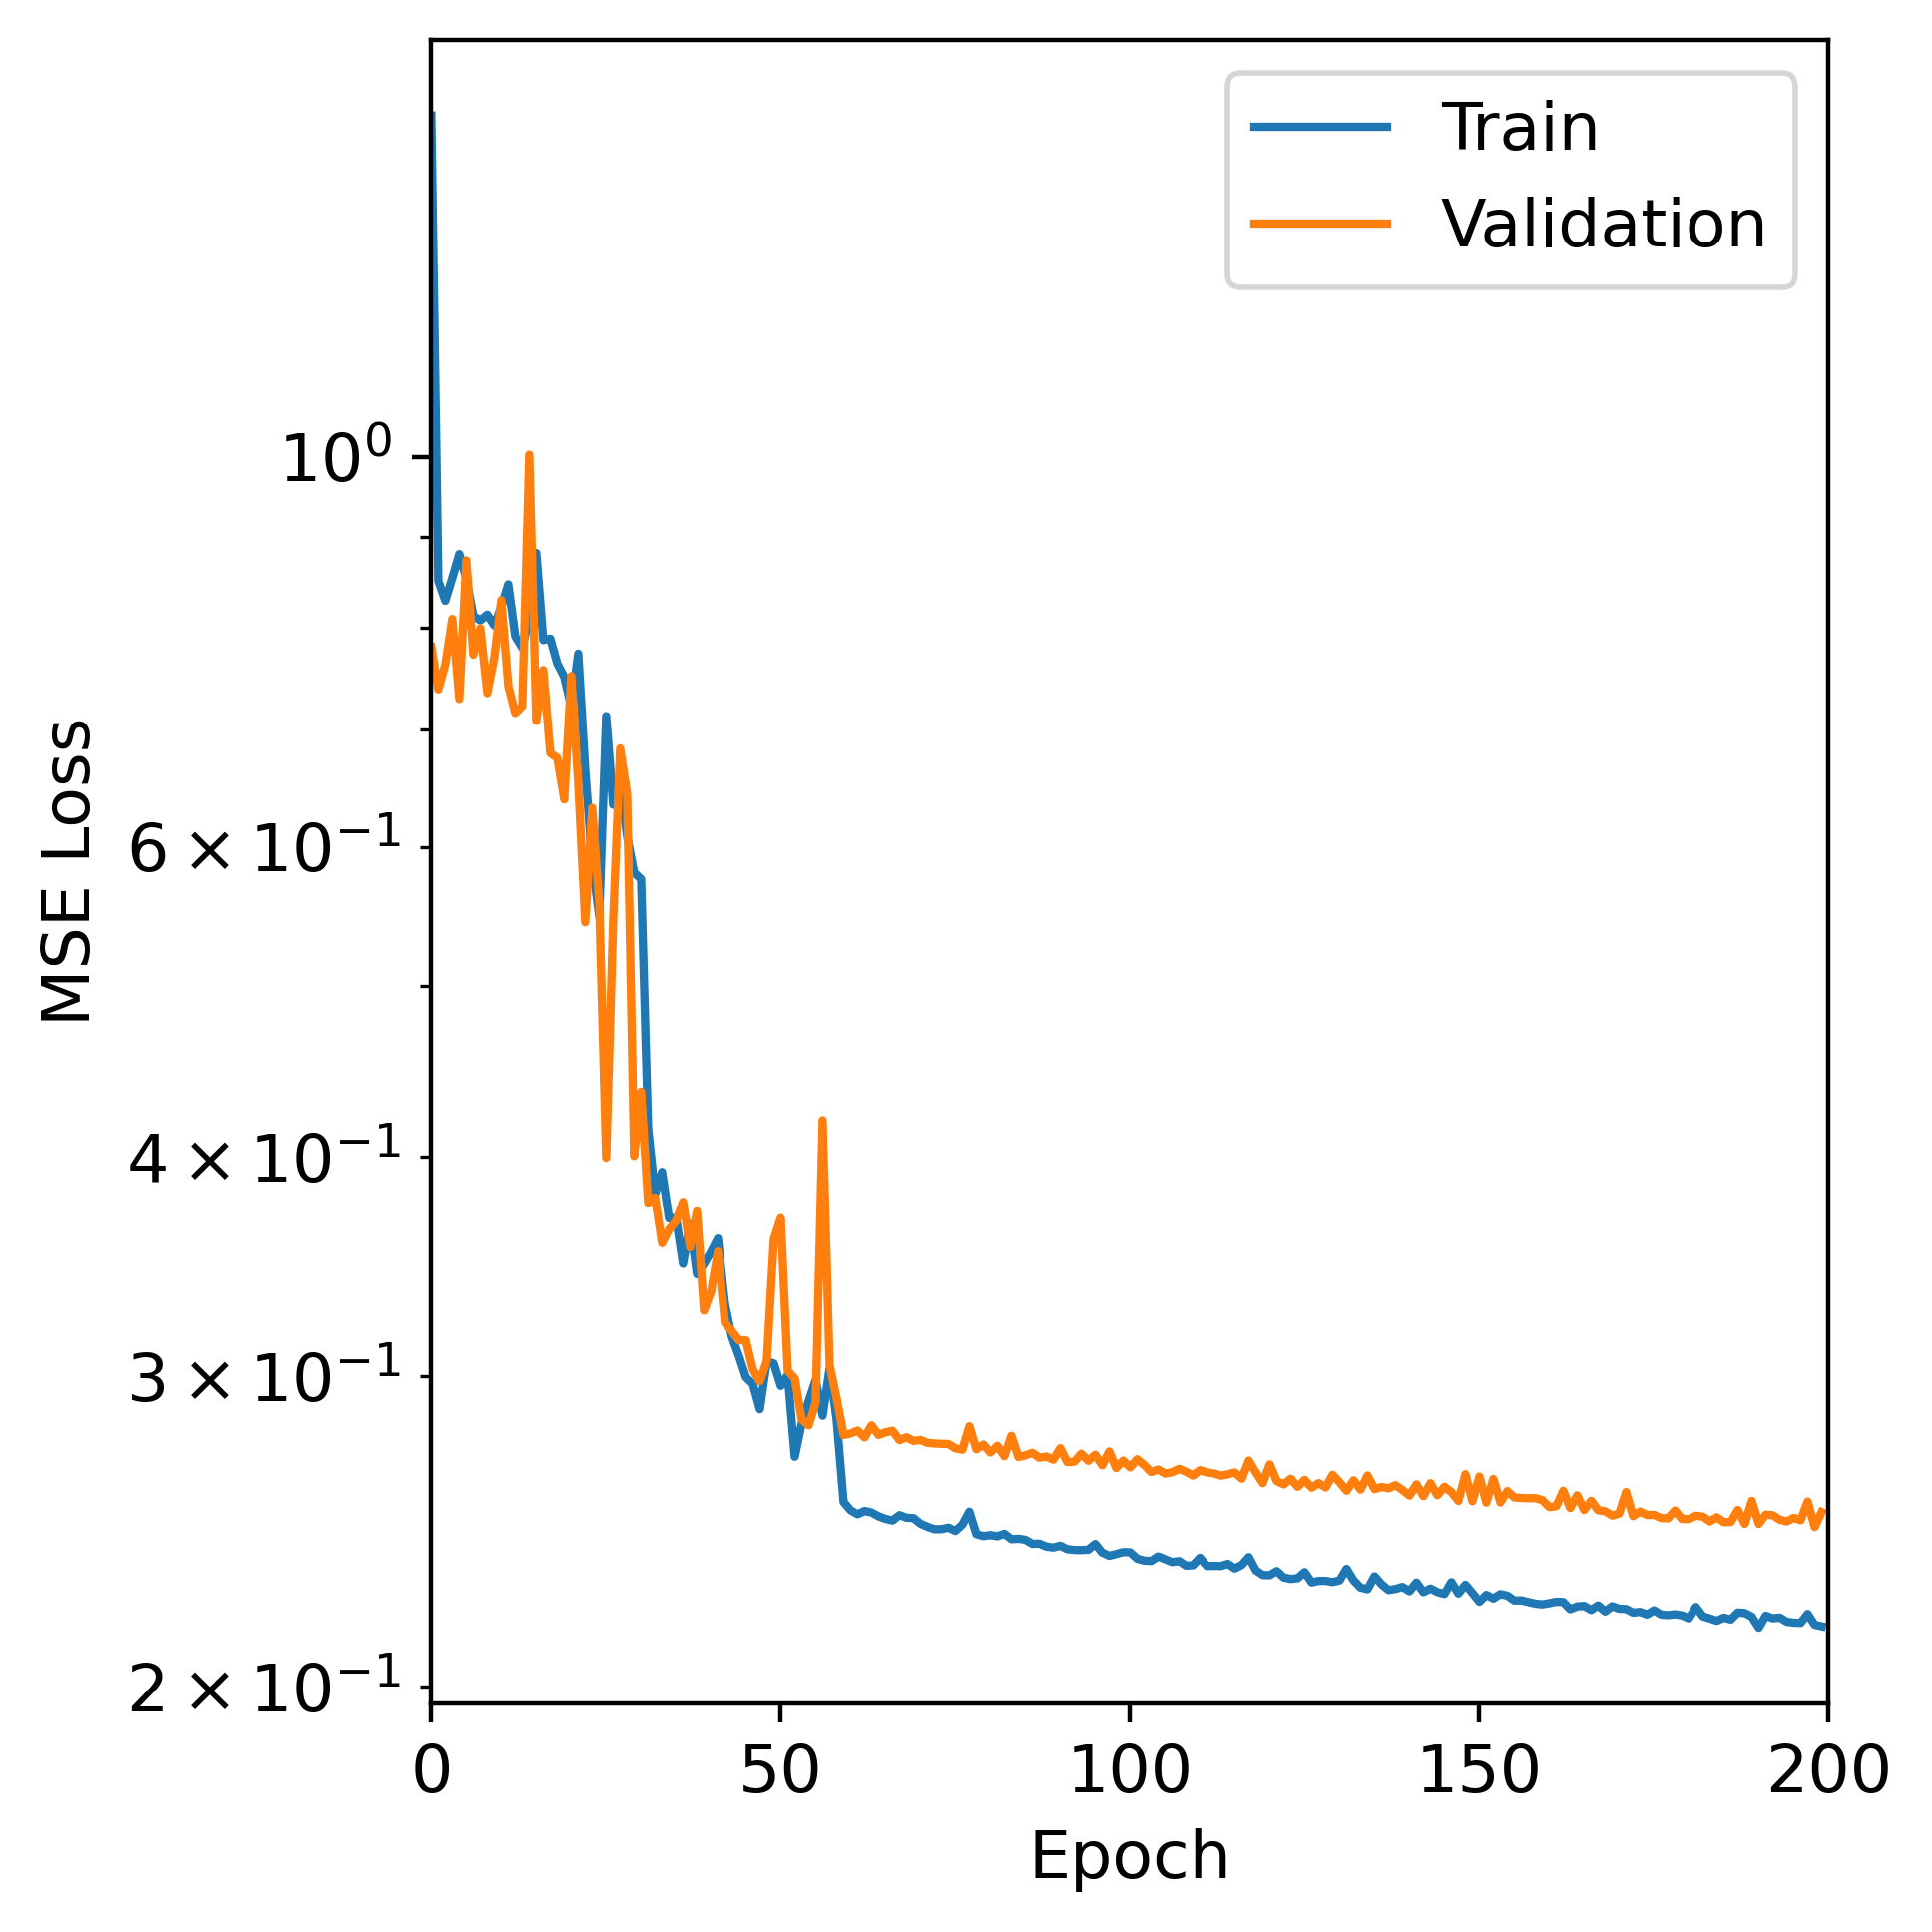

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5), dpi=400) 

plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 12

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale("log") 
plt.xlim(0,epoch_num)
plt.tight_layout() 

# Save model

In [11]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

## Training and Validation data

Test R2 for E: 0.7318387031555176


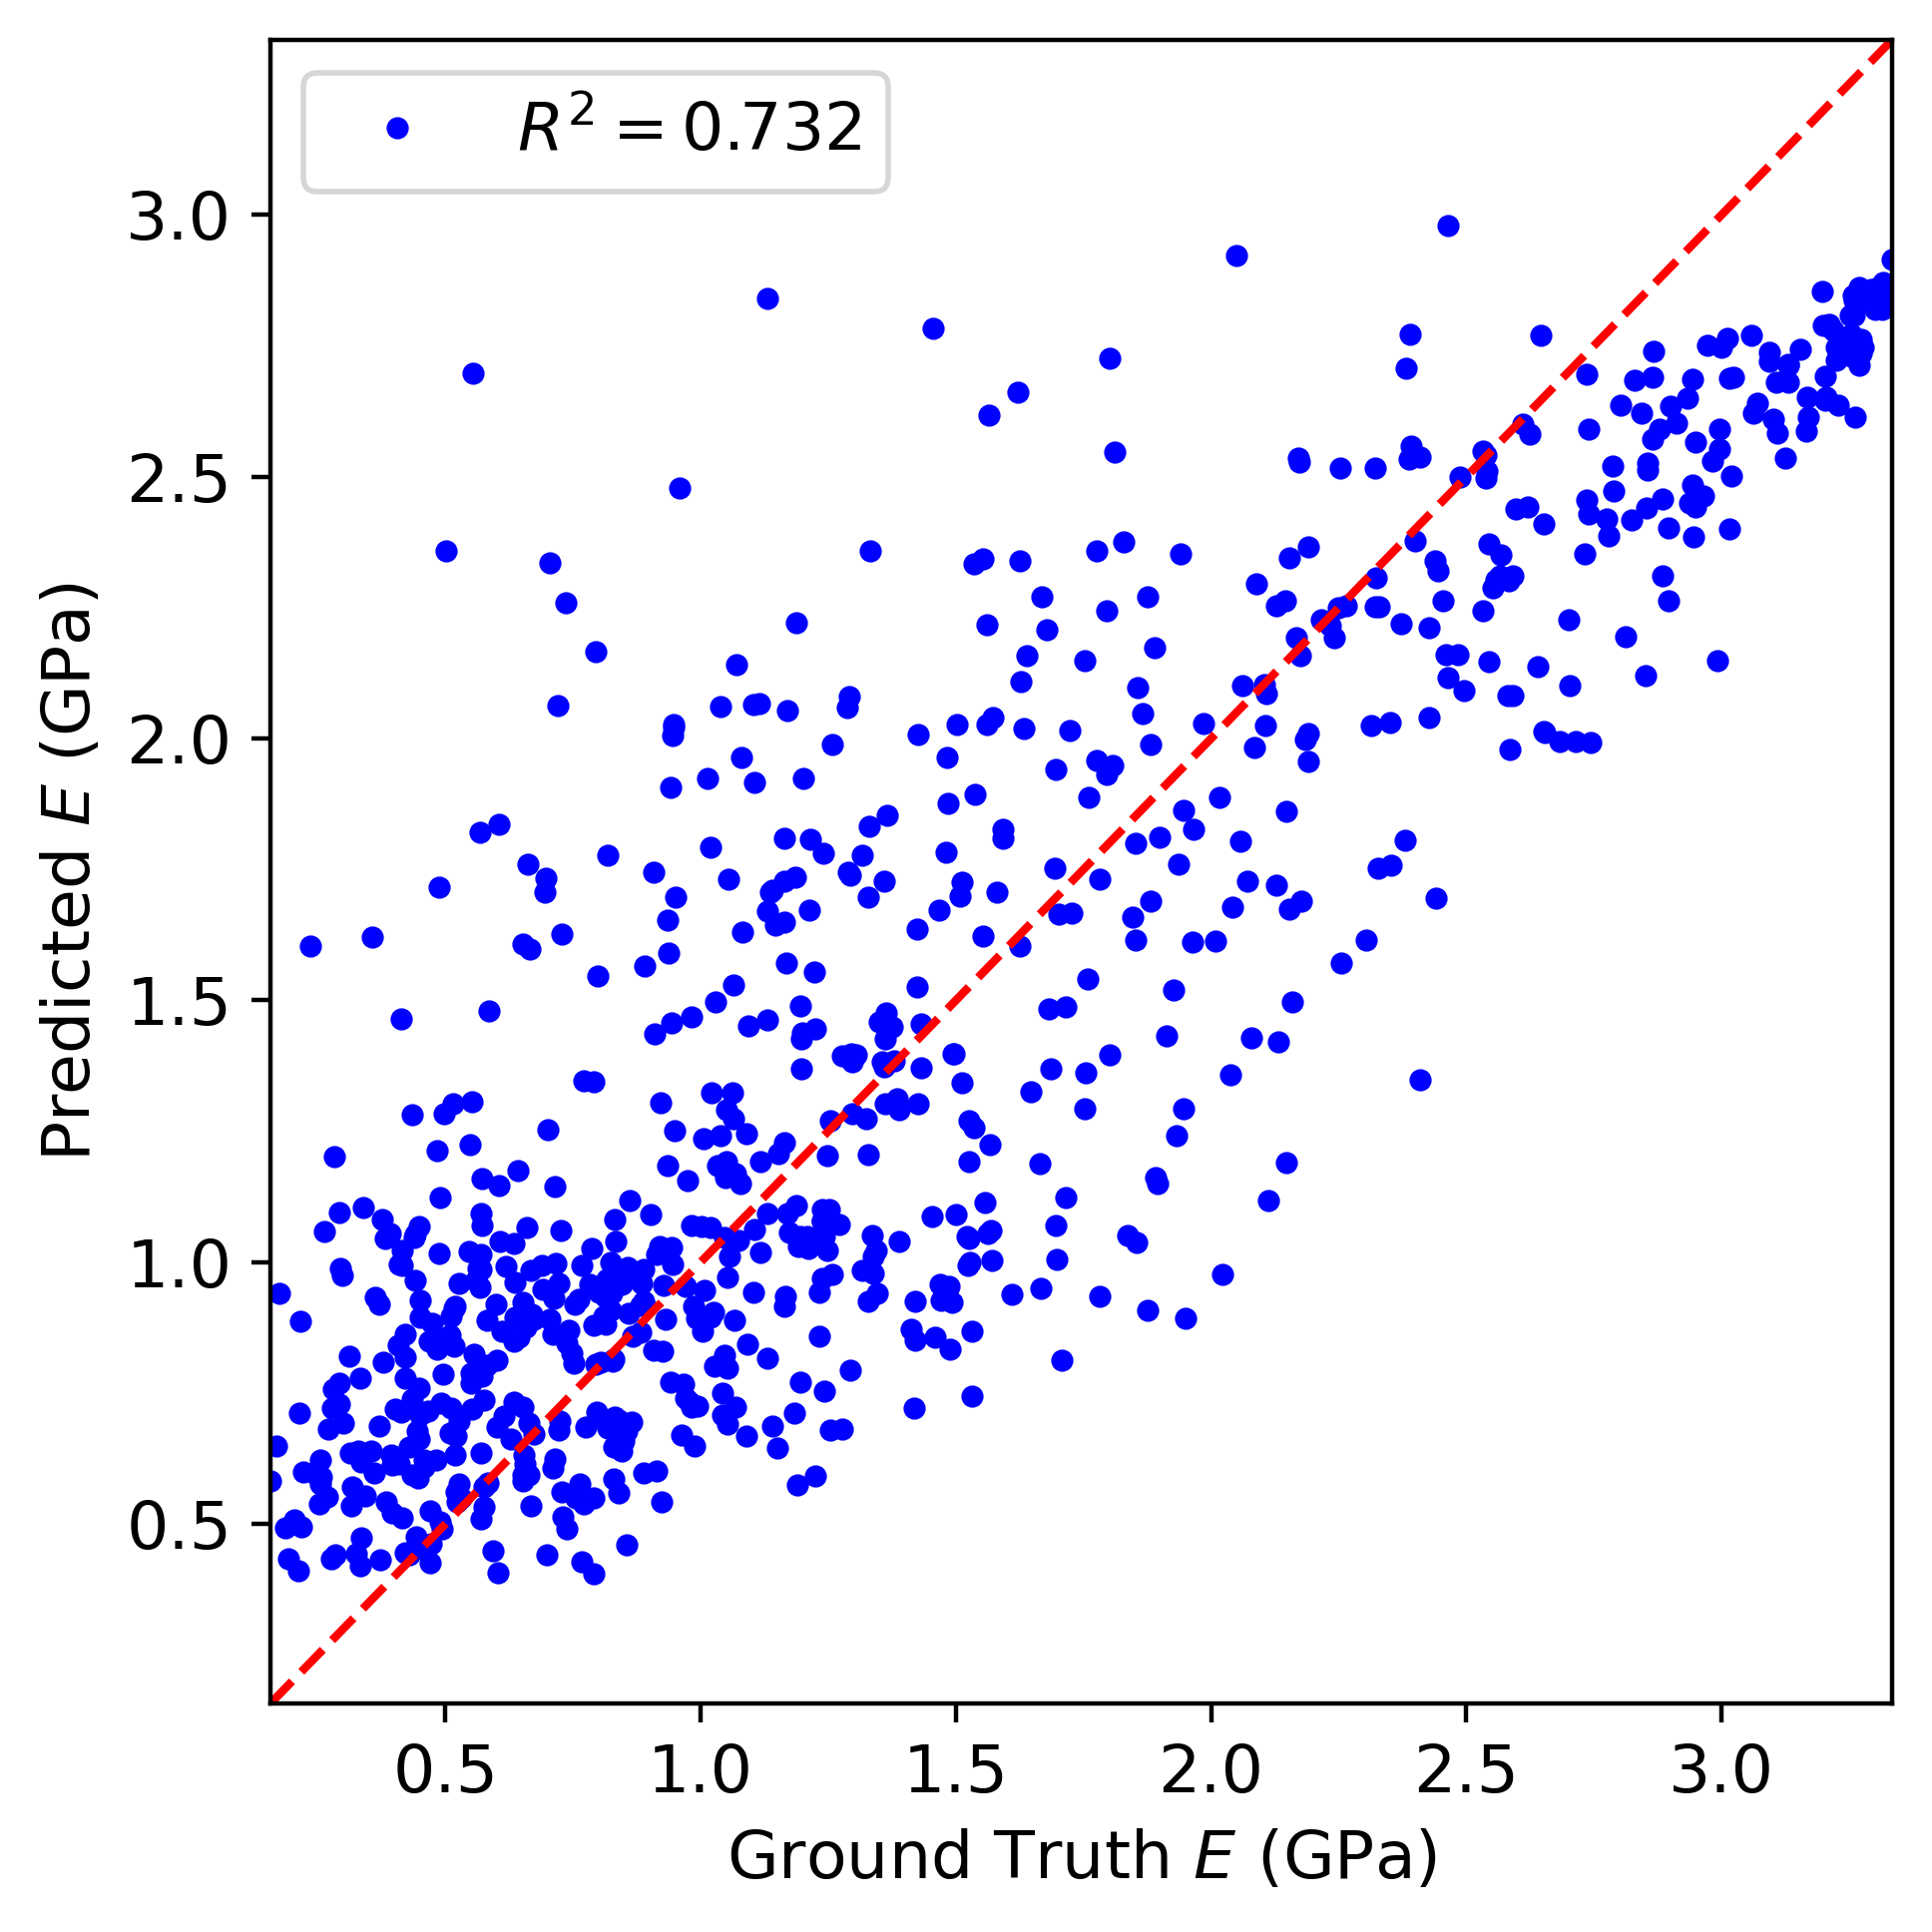

In [12]:
R2 = evaluate_model(model, train_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.658815860748291


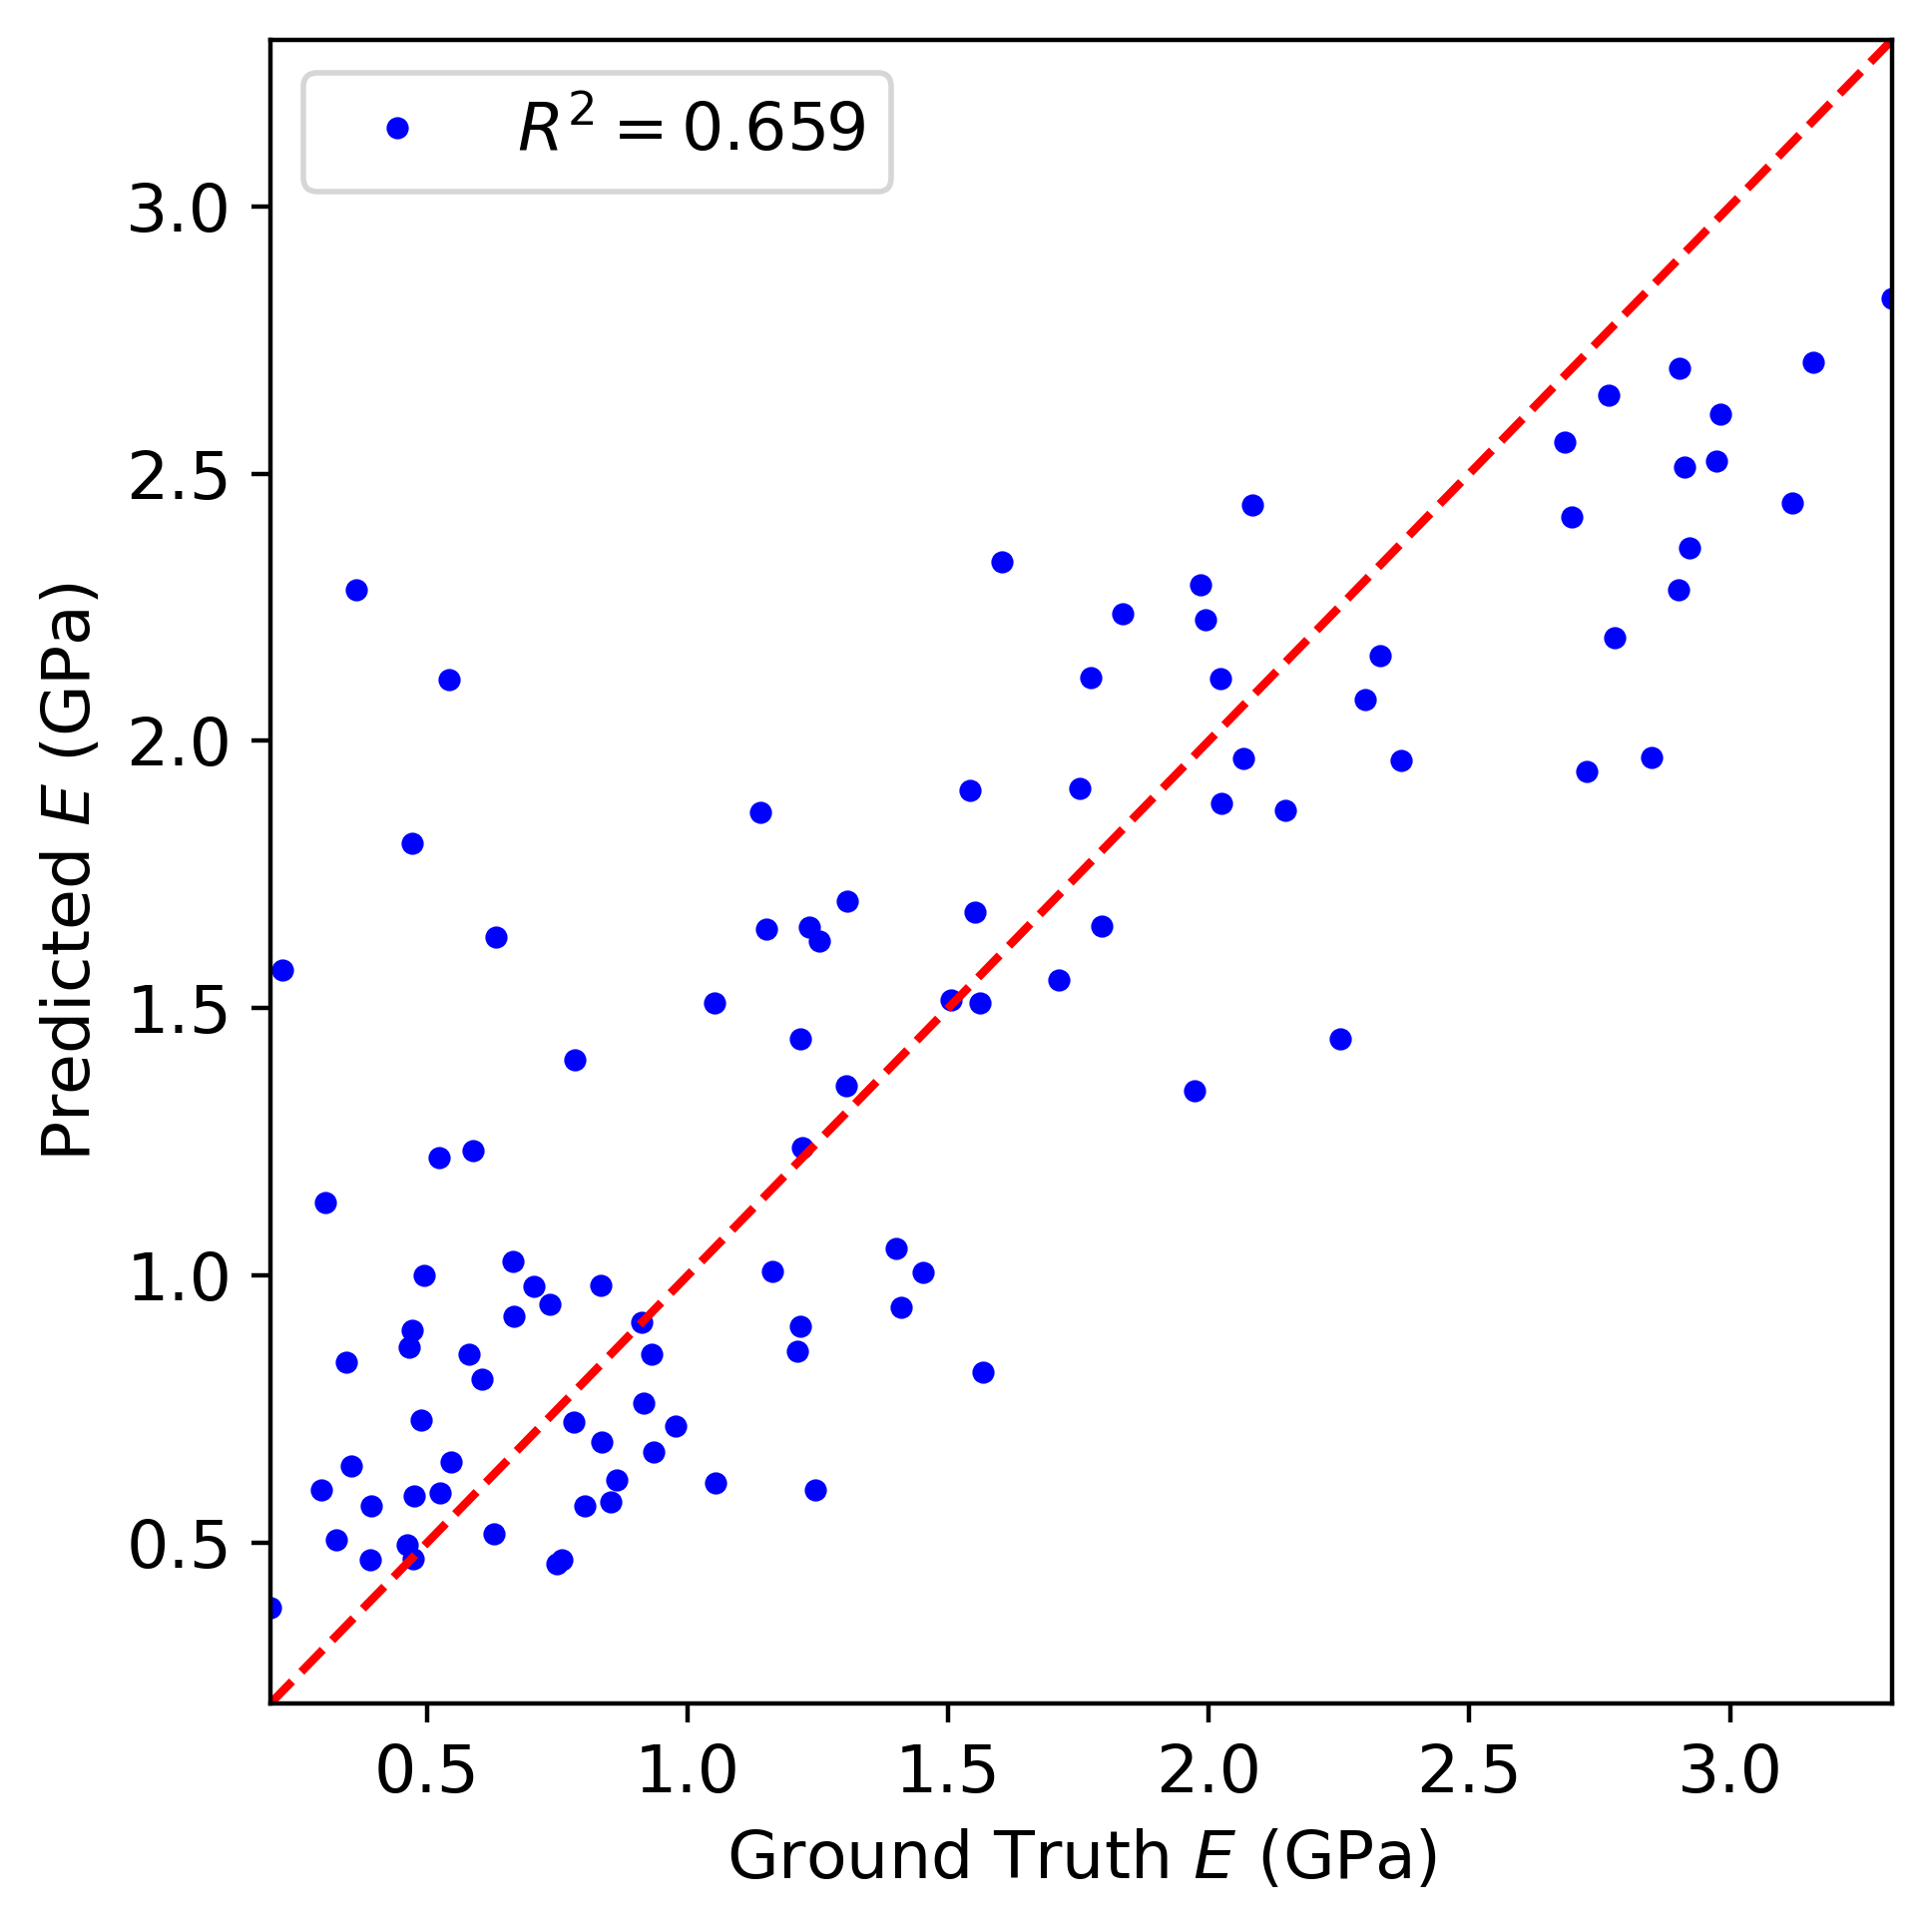

In [13]:
R2 = evaluate_model(model, test_loader, device, args.cover_interval, overlap, args.save_model_dir)

## Testing data

Test R2 for E: 0.5920151472091675


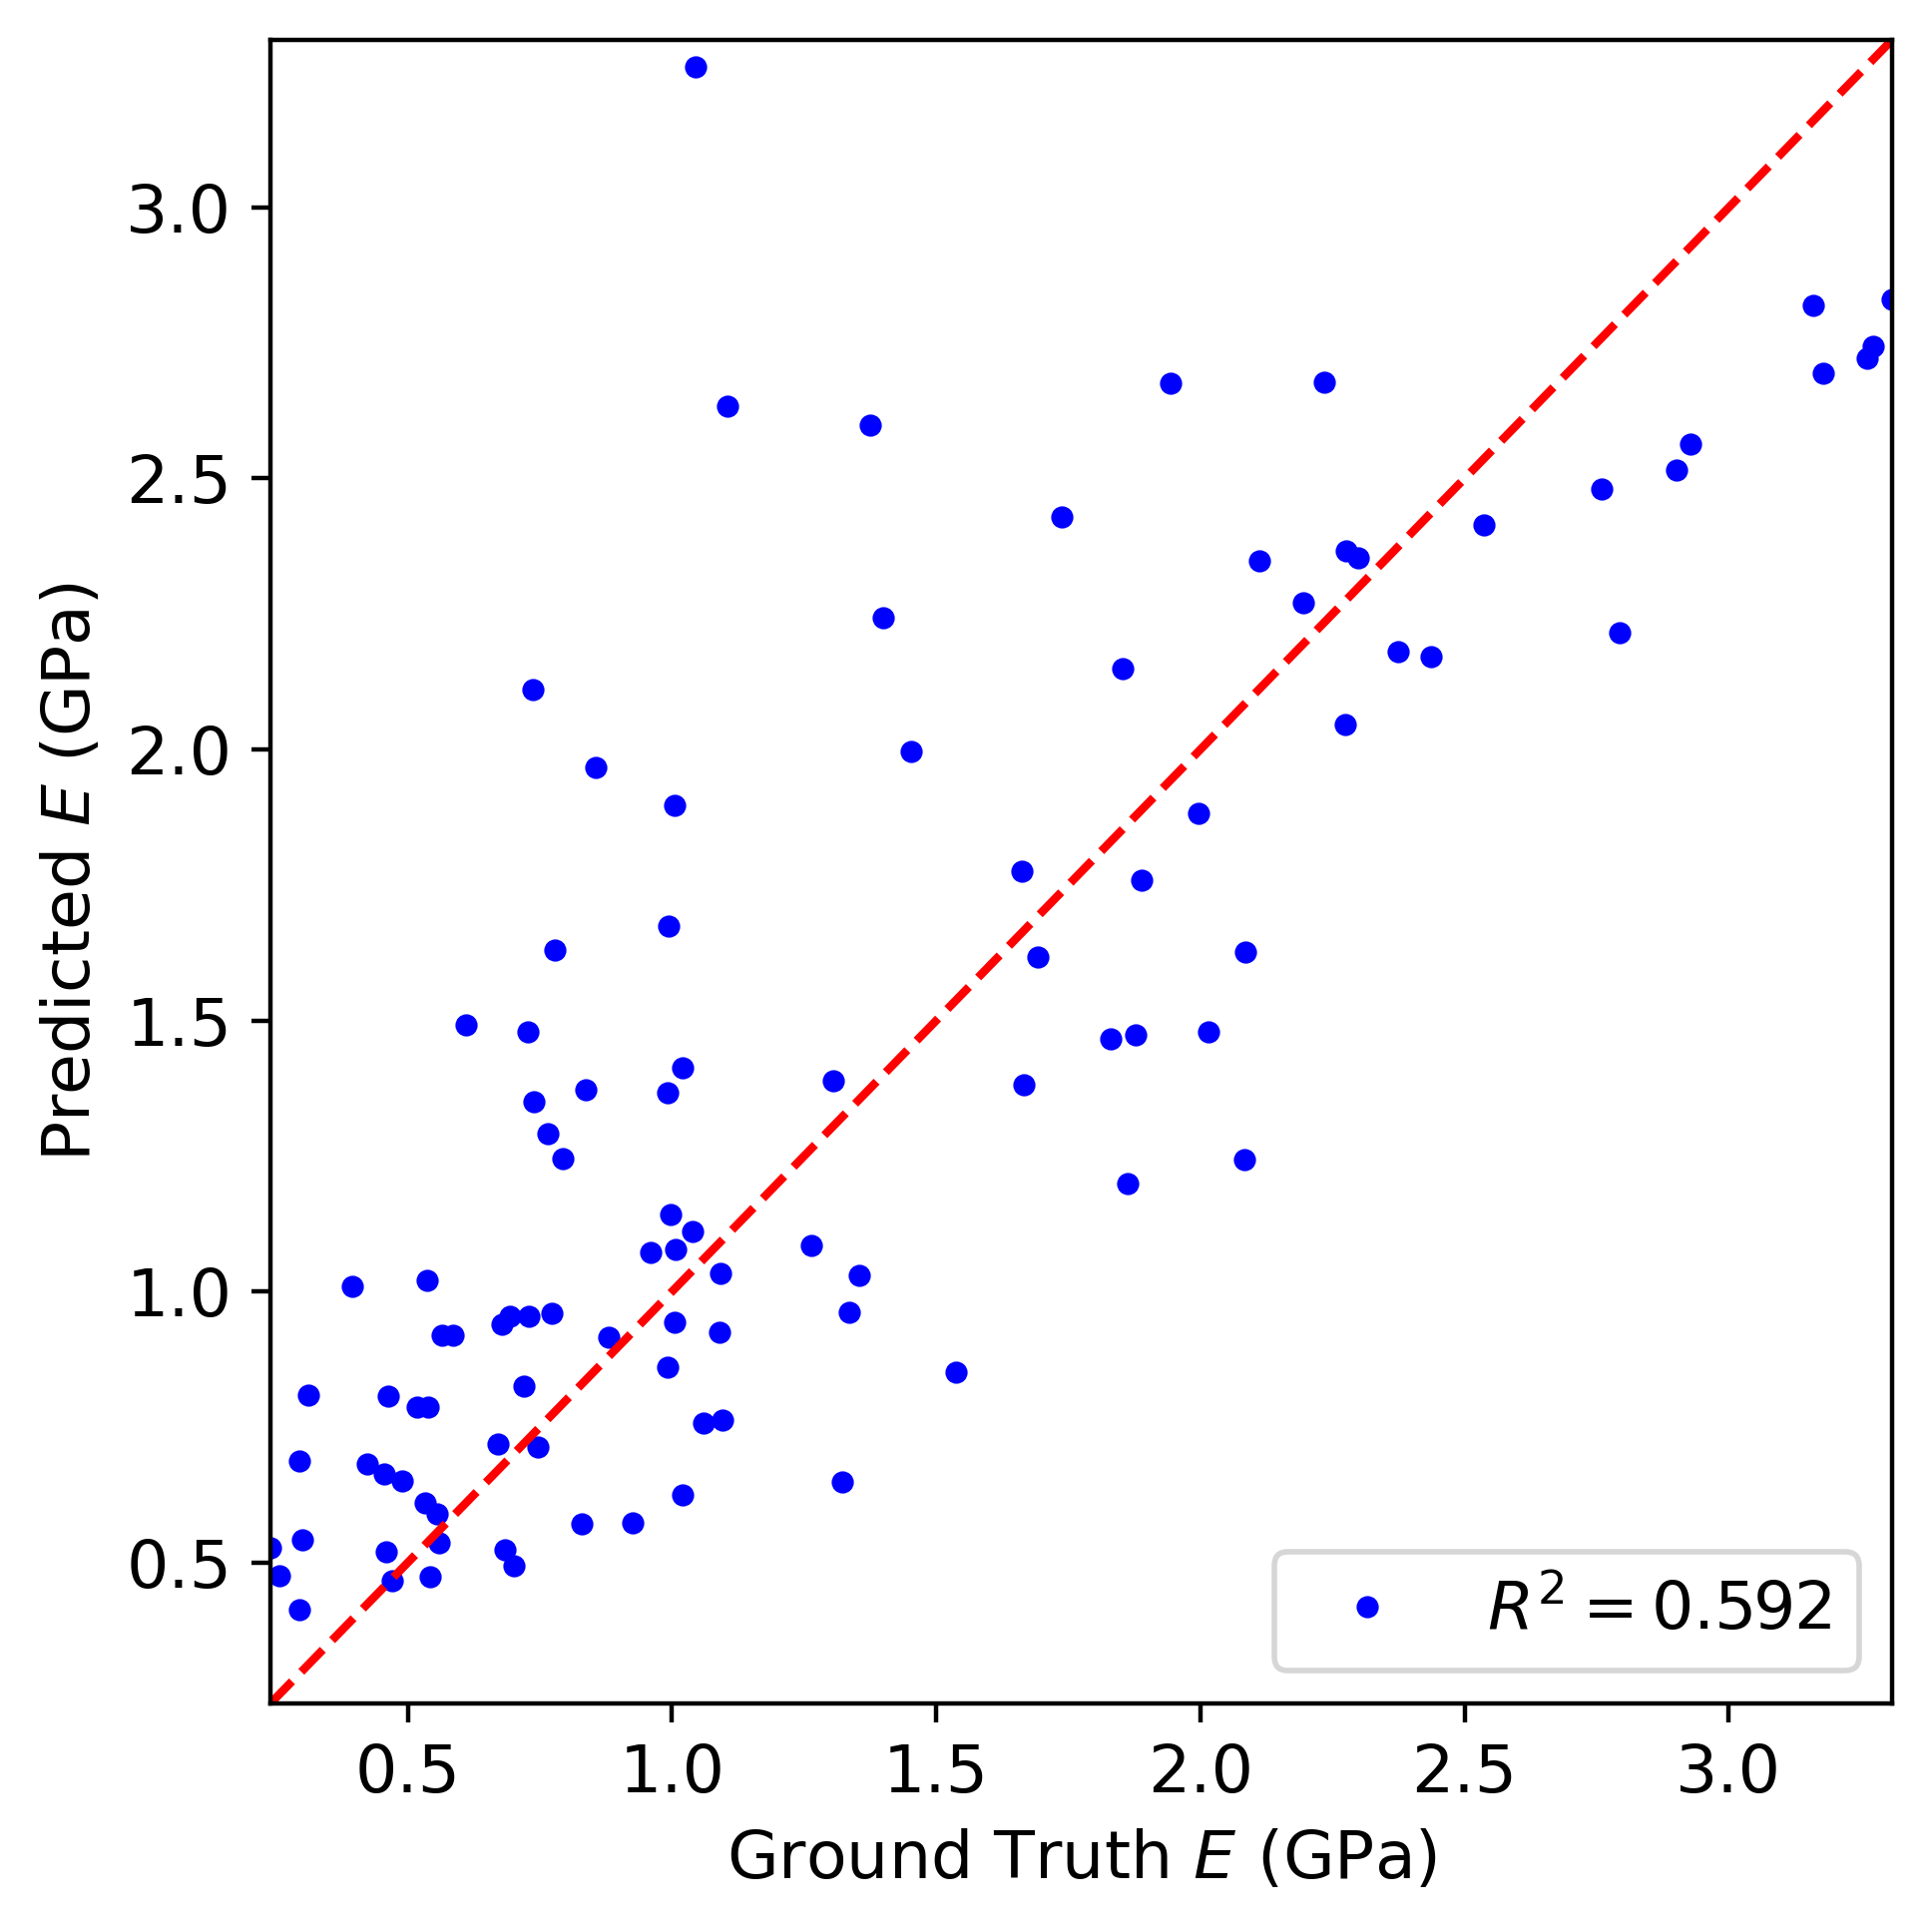

In [14]:
R2 = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)